<a href="https://colab.research.google.com/github/Killian-Susini/Proj_Deep/blob/main/deep_learning_AST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
!pip install -q numba==0.53.1
!pip install -q numpy==1.20.3
!pip install -q scikit-learn==0.24.2
!pip install -q scipy==1.6.3
!pip install -q sklearn==0.0
!pip install -q timm==0.4.5
!pip install -q torch==1.8.1
!pip install -q torchaudio==0.8.1
!pip install -q wget==3.2

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 25.3 MB 1.4 MB/s 
     |████████████████████████████████| 15.3 MB 4.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.20.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.20.3 which is incompatible.
     |█████████████████

In [ ]:
import pandas as pd
import os
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import torch.nn.functional
from torch.utils.data import Dataset
import numpy as np
from sklearn import metrics
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# DATALOADER

In [ ]:
def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

class FSD50Dataset(Dataset):
  def __init__(self, df_data, split, label_to_index, mel_bins=128, frame_shift=10, target_len=1024, timem=0, freqm=0, mean=-3.3852494, std=4.416891):
    self.split = split
    self.df_data = df_data[df_data['split']==split].reset_index(drop=True)
    #Look-up dict for output
    self.label_to_index = label_to_index
    self.label_num = len(set(df_data['label'].values))
    self.melbins = mel_bins
    self.frameshift = frame_shift
    self.target_len = target_len
    self.timem = timem
    self.freqm = freqm
    self.norm_std = std
    self.norm_mean = mean

  def __getitem__(self, index):
    #Read in audio
    file_path = os.path.join(self.df_data.loc[index, 'dir_path'], f"{self.df_data.loc[index, 'fname']}.wav")
    waveform, sr = open(file_path)

    #Tranform raw audio into filter bank
    #Filter banks and spectrograms are essentially the same, except spectrograms divides the time domain into slices while the fbank slices the frequency domain into slices 
    X = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr,
                                                  window_type='hamming', num_mel_bins=self.melbins, frame_shift=self.frameshift)
    
    #Get number of frames and pad if inferior to target length
    n_frames = X.shape[0]
    p = self.target_len - n_frames
    if p > 0:
      m = torch.nn.ZeroPad2d((0, 0, 0, p))
      X = m(X)
    elif p < 0:
      X = X[0:self.target_len, :]

    #Data augmentation using time and frequency masks so the model generalizes better
    #Only done on train set
    if self.split == 'train' and self.freqm != 0:
      #In order to correctly apply the time and frequency masks, we need to transpose the data
      X = torch.transpose(X, 0, 1)
      X = torchaudio.transforms.FrequencyMasking(self.freqm)(X)
      X = torchaudio.transforms.TimeMasking(self.timem)(X)
      X = torch.transpose(X, 0, 1)

    #normalize with mean and std (calculated in utils.ipynb)
    X = (X - self.norm_mean) / (self.norm_std * 2)

    #Get labels
    label_pos = self.df_data.loc[index, 'label']
    y = np.zeros(self.label_num)
    y[self.label_to_index[label_pos]] = 1.0

    return X, y
    
  def __len__(self):
    return self.df_data.shape[0]


# Model

The idea here is to download the pretrained model, shape the Input linear projection layer to have the dimensions of the input and add a linear layer at the end to predict the class of the inputs.

We need to make a couple modifications to the pretrained model because we are handling audio input and not image input, like sum the weights of the vision transformer and keep a positional embedding to keep track of where we are spatially in the spectrogram:

<br>
<img src='https://drive.google.com/uc?id=1UTjVqND4WgDXZDMmMZruvNvaExUFpq2x' height="350">
<br>

Code based on [YuanGongND/ast](https://github.com/YuanGongND/ast)




In [ ]:
!pip install -q timm==0.4.5

     |████████████████████████████████| 287 kB 8.4 MB/s 


In [ ]:
import timm
from timm.models.layers import to_2tuple,trunc_normal_
import torch.nn as nn
from torch.cuda.amp import autocast

In [ ]:
class ASTModel(nn.Module):
  
    def __init__(self, label_dim, fstride=10, tstride=10, input_fdim=128, input_tdim=1024):
        """
        AST model
        :param label_dim: number of output classes
        :param fstride: stride on frequency axis (seeing that our patches are 16x16, if fstride < 16, there will be overlap in our different paches)
        :param tstride: stride on time axis (seeing that our patches are 16x16, if tstride < 16, there will be overlap)
        :param input_fdim: frequency dimension
        :param input_tdim: time dimension
        """
        super(ASTModel, self).__init__()
  
        #Initialize PatchEmbedded class to the custom model set below
        timm.models.vision_transformer.PatchEmbed = PatchEmbed
        
        #Load in pretrained model, in this case Visition Transformer
        #In experiements, we try different 'sizes' of models
        self.v = timm.create_model('vit_deit_tiny_distilled_patch16_224', pretrained=True)
        #self.v = timm.create_model('vit_deit_small_distilled_patch16_224', pretrained=True)
        #self.v = timm.create_model('vit_deit_base_distilled_patch16_224', pretrained=True)

        #Get the dimensions of the pretrained model
        #Number of patches we want to split our filter bank into
        self.original_num_patches = self.v.patch_embed.num_patches
        #Dimensions of intput in pretrained are square
        self.oringal_hw = int(self.original_num_patches ** 0.5)
        self.original_embedding_dim = self.v.pos_embed.shape[2]
        #Add a linear layer at the end of the pretrained model that the ouput will have the same dimensions as the number of classes
        self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

        #Get shape of necessary number of patches by calling the get_shape function (varies depending on the value of t&fstride)
        f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
        num_patches = f_dim * t_dim
        self.v.patch_embed.num_patches = num_patches

        #Create first linear projectionn layer
        #Output is the size of the 1d embedding, kernel size is the size of a patch, and stride is defined as above
        new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        #Sum the weights of the ViT transformer (only one channel vs. 3)
        new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
        new_proj.bias = self.v.patch_embed.proj.bias
        self.v.patch_embed.proj = new_proj

        #We need to reshape the pretrained positional embedding in order to fit to our new number of patches
        new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, self.original_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, self.oringal_hw, self.oringal_hw)
        #if t_dim < self.original_hw means there's going to be overlap in our patches on the time dimension so the calculation is slightly different
        if t_dim <= self.oringal_hw:
            new_pos_embed = new_pos_embed[:, :, :, int(self.oringal_hw / 2) - int(t_dim / 2): int(self.oringal_hw / 2) - int(t_dim / 2) + t_dim]
        else:
            new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(self.oringal_hw, t_dim), mode='bilinear')
        
        #if f_dim < self.original_hw means there's going to be overlap in our patches on the frequency dimension so the calculation is slightly different
        if f_dim <= self.oringal_hw:
            new_pos_embed = new_pos_embed[:, :, int(self.oringal_hw / 2) - int(f_dim / 2): int(self.oringal_hw / 2) - int(f_dim / 2) + f_dim, :]
        else:
            new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
        
        #Turn positional embedding from 2d to 1d (because input to embedding layer will be in one dimention)
        new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1,2)

        #Append the embedding layer to the position and distillation tokens
        self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))

    def get_shape(self, fstride, tstride, input_fdim=128, input_tdim=1024):
        """
        Helper method for init
        Returns patch shapes after projection layer
        :param fstride: stride on frequency axis (seeing that our patches are 16x16, if fstride < 16, there will be overlap in our different paches)
        :param tstride: stride on time axis (seeing that our patches are 16x16, if tstride < 16, there will be overlap)
        :param input_fdim: frequency dimension
        :param input_tdim: time dimension
        """
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    @autocast()
    def forward(self, x):
        """
        :param x: input in the sahep of [batch_size, target_length, mel_bins]
        :return: class prediction vector
        """
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)
        bacth_size = x.shape[0]

        #Pass the data through the linear projection layer
        x = self.v.patch_embed(x)

        #Both of these tokens are used in the original transformer model
        #class token
        cls_tokens = self.v.cls_token.expand(bacth_size, -1, -1)
        #distillation token (to make sure the student learns from the teacher through attention)
        dist_token = self.v.dist_token.expand(bacth_size, -1, -1)

        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        #Add positional embedding (to be spatially aware of where the current patche is in the spectrogram) to the linear projection
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)

        #Feed the data through all the layers in pretrained model
        for blk in self.v.blocks:
            x = blk(x)

        #Normalise and predict class
        x = self.v.norm(x)
        x = (x[:, 0] + x[:, 1]) / 2
        x = self.mlp_head(x)
        return x

class PatchEmbed(nn.Module):
    """
    Customized Patch Embedding class in order to reshape layers that were built for the pretrained model image input of specific size 224x224 to fit our audio data
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)

        return x


In [ ]:
from torchsummary import summary

model = ASTModel(label_dim=5)
summary(model, (128, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 192, 101, 12]          49,344
        PatchEmbed-2            [-1, 1212, 192]               0
           Dropout-3            [-1, 1214, 192]               0
         LayerNorm-4            [-1, 1214, 192]             384
            Linear-5            [-1, 1214, 576]         111,168
           Dropout-6        [-1, 3, 1214, 1214]               0
            Linear-7            [-1, 1214, 192]          37,056
           Dropout-8            [-1, 1214, 192]               0
         Attention-9            [-1, 1214, 192]               0
         Identity-10            [-1, 1214, 192]               0
        LayerNorm-11            [-1, 1214, 192]             384
           Linear-12            [-1, 1214, 768]         148,224
             GELU-13            [-1, 1214, 768]               0
          Dropout-14            [-1, 12

# Train/Test Functions

In [ ]:
import sys
import time
import pickle
from collections import OrderedDict

In [ ]:
#Object that stores and keeps track of current metric
class AverageMeter(object):
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    #Update the counter with current values
    #n == batch size
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    #Return average
    def return_avg(self):
      return self.avg


In [ ]:
def calculate_stats(y_pred, y):
    """
    Calculate performance metrics on validation and test sets
    return accurancy and mAP
    """
    classes_num = y.shape[-1]

    # Get Accuracy
    acc = metrics.accuracy_score(np.argmax(y.cpu().numpy(), 1), np.argmax(y_pred.cpu().numpy(), 1))  
    agg_avg_precision = []
    
    # Calculate mAP by iteratively calculating average precision score by class 
    for k in range(classes_num):
        avg_precision = metrics.average_precision_score(y[:, k].cpu().numpy(), y_pred[:, k].cpu().numpy(), average=None)
        agg_avg_precision.append(avg_precision)
        
    return acc, np.mean(agg_avg_precision)


def evaluate(device, audio_model, val_loader, loss_fn, desc='Eval'):
    """
    Function called to evaluate validation and test sets at the end of an epoch or training
    """
    # switch to evaluate mode
    audio_model.eval()

    loss_meter = AverageMeter()
    agg_predictions = []
    agg_gt = []
    pbar = tqdm(enumerate(val_loader), total=len(val_loader), desc=desc)

    with torch.no_grad():
        for i, (X, y) in enumerate(val_loader):
            batch_size = X.size(0)
            X = X.to(device)
            y = y.to(device)

            # compute output
            y_pred = audio_model(X)
            # we don't apply the last sigmoid layer during training
            y_pred = torch.sigmoid(y_pred)
            predictions = y_pred.to('cpu').detach()

            agg_predictions.append(predictions)
            agg_gt.append(y)

            # compute the loss
            loss = loss_fn(y_pred, torch.argmax(y.long(), axis=1))
            loss_meter.update(loss.item(), batch_size)

            pbar.update(1)


        predictions = torch.cat(agg_predictions)
        ground_truth = torch.cat(agg_gt)
        acc, mAP = calculate_stats(predictions, ground_truth)
        loss = loss_meter.return_avg()

    return acc, mAP, loss


def train_epoch(device, audio_model, train_loader, optimizer, loss_fn, epoch): 
    """
    Function called to train one epoch
    returns average loss during training
    """
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch [{epoch}]')
  
    # Initialize AverageMeter object to keep track of loss
    loss_meter = AverageMeter()
    audio_model.train()

    for i, (X, y) in enumerate(train_loader):
      ##Data to device
      batch_size = X.size(0)
      X = X.to(device, non_blocking=True)
      y = y.to(device, non_blocking=True)

      #Predict output and calculate loss
      with autocast():
          y_pred = audio_model(X)
          loss = loss_fn(y_pred, torch.argmax(y.long(), axis=1))

      #optimizer and loss step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      loss_meter.update(loss.item(), batch_size)
      pbar.update(1)
      
    pbar.close()
    return loss_meter.return_avg()

def optimizer_to(optim, device):
    """
    Function to send optimizer params to gpu (used when loading in model)
    https://discuss.pytorch.org/t/moving-optimizer-from-cpu-to-gpu/96068/3
    """
    for param in optim.state.values():
        # Not sure there are any global tensors in the state dict
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(device)


def train_test(audio_model, optimizer, train_loader, val_loader, test_loader, output_dir, results, lr, epoch=0, load=False):
    """
    Run whole training and test
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.set_grad_enabled(True)

    #parallelize model so we can compute batches simultaneously (speeds up train time)
    if not isinstance(audio_model, nn.DataParallel):
        audio_model = nn.DataParallel(audio_model)
    audio_model = audio_model.to(device)
    
    #If we loaded model, it's currently on cpu and we need to send it to GPU
    if load:
      optimizer_to(optimizer,device)

    ##Cross Entropy because we have multiple classes
    loss_fn = nn.CrossEntropyLoss()
    #loss_fn = nn.BCEWithLogitsLoss()

    epoch += 1
    while epoch < n_epochs + 1:
      #Train epoch
      train_loss = train_epoch(device, audio_model, train_loader, optimizer, loss_fn, epoch)
      #Evaluate model
      acc, mAP, val_loss = evaluate(device, audio_model, val_loader, loss_fn)
      
      #Print out and keep track of epoch results
      print("acc: {:.6f}".format(acc))
      print("mAP: {:.6f}".format(mAP))
      print("train_loss: {:.6f}".format(train_loss))
      print("validation_loss: {:.6f}".format(val_loss))

      result_epoch = pd.DataFrame({'epoch' : [epoch],
                                   'acc' : [acc], 
                                   'mAP' : [mAP], 
                                   'train_loss' : [train_loss],
                                   'val_loss' : [val_loss],
                                   'model_save' : [0]})      

      model_path = os.path.join(output_dir, 'model_latest.pt')
      optimizer_path = os.path.join(output_dir, 'optimizer_latest.pt')
      results_path = os.path.join(output_dir, 'results.csv')

      if not os.path.isdir(output_dir):
        os.mkdir(output_dir)

      #save model if validation loss is better than previous epoch
      if epoch > 1 and results.iloc[-1].val_loss > val_loss:
        torch.save(audio_model.state_dict(), model_path)
        torch.save(optimizer.state_dict(), optimizer_path)

        results['model_save'] = 0
        result_epoch['model_save'] = 1

      results = pd.concat([results, result_epoch], ignore_index=True)
      results.to_csv(results_path, index=False)
      epoch += 1

    #Get test performance after whole training
    acc, mAP, test_loss = evaluate(device, audio_model, test_loader, loss_fn, desc='Test')
    print("[TEST] acc: {:.6f}".format(acc))
    print("[TEST] mAP: {:.6f}".format(mAP))
    print("[TEST] loss: {:.6f}".format(test_loss))

    test_perf = pd.DataFrame({'acc' : [acc], 
                              'mAP' : [mAP], 
                              'loss' : [test_loss]})      

    #save test results
    test_path = os.path.join(output_dir, 'test_performance.csv')
    test_perf.to_csv(test_path)

    #Return training results
    return results


# Run Model

In [ ]:
#Read in data
dataset_path = '/content/drive/MyDrive/colab_notebooks/deep_learning/deep_learning_project/FSD50K'
df_data = pd.read_csv(os.path.join(dataset_path, 'dataset_slim.csv'))

#Create dictionary to map labels to indices in y
labels = sorted(list(set(df_data['label'].values)))
label_to_index = {l:i for l, i in zip(labels, range(len(labels)))}
index_to_label = dict((v,k) for k,v in label_to_index.items())

#batch_size = 16
batch_size = 8
num_workers = 2
freqm = 24
timem = 192

train_loader = torch.utils.data.DataLoader(
            FSD50Dataset(df_data, 'train', label_to_index, timem=timem, freqm=freqm),
            batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)


val_loader = torch.utils.data.DataLoader(
            FSD50Dataset(df_data, 'val', label_to_index),
            batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
            FSD50Dataset(df_data, 'test',  label_to_index),
            batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)


In [ ]:
#Uncomment next two lines if you want to start training from scratch
LOAD_MODEL = False
ouput_dir = None

#Uncomment next line if you want to load previous training weights
#LOAD_MODEL = True
#output_dir = '/content/drive/MyDrive/colab_notebooks/deep_learning/deep_learning_project/output/21-01-2022_13:24:35'

In [ ]:
n_epochs = 5
lr = 0.000005

audio_model = ASTModel(label_dim=len(labels))
#Adam optimizer (like in the paper)
optimizer = torch.optim.Adam(audio_model.parameters(), lr)

if LOAD_MODEL:
    model_path = os.path.join(output_dir, 'model_latest.pt')
    results_path = os.path.join(output_dir, 'results.csv')
    optimizer_path = os.path.join(output_dir, 'optimizer_latest.pt')

    #the model dict is saved with slightly different keys than needed for the load
    model_weights = torch.load(model_path)
    audio_model.load_state_dict(OrderedDict([(k.replace('module.', ''), v) for k,v in model_weights.items()]))
    optimizer.load_state_dict(torch.load(optimizer_path))

    results = pd.read_csv(results_path)
    epoch = np.max(results['epoch'].values)
    n_epochs += epoch
else:
    #create output directory name from current time
    output_dir = f'/content/drive/MyDrive/colab_notebooks/deep_learning/deep_learning_project/output/{datetime.now().strftime("%d-%m-%Y_%H:%M:%S")}'
    results = pd.DataFrame(columns = ['epoch','acc','mAP','train_loss','val_loss','model_save'])
    epoch = 0

results = train_test(audio_model, optimizer, train_loader, val_loader, test_loader, output_dir, results, lr, epoch=epoch, load=LOAD_MODEL)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)

Epoch [1]: 100%|██████████| 853/853 [03:17<00:00,  4.31it/s]

Eval: 100%|██████████| 198/198 [00:27<00:00,  7.19it/s]

acc: 0.699367
mAP: 0.765063
train_loss: 1.002382
validation_loss: 1.314147




Epoch [2]: 100%|██████████| 853/853 [03:18<00:00,  4.30it/s]

Eval: 100%|██████████| 198/198 [00:27<00:00,  7.25it/s]


acc: 0.781013
mAP: 0.840350
train_loss: 0.660506
validation_loss: 1.260960



Epoch [3]: 100%|██████████| 853/853 [03:18<00:00,  4.29it/s]

Eval: 100%|██████████| 198/198 [00:27<00:00,  7.21it/s]


acc: 0.800000
mAP: 0.867628
train_loss: 0.542225
validation_loss: 1.238674



Epoch [4]: 100%|██████████| 853/853 [03:18<00:00,  4.30it/s]

Eval: 100%|██████████| 198/198 [00:27<00:00,  7.12it/s]


acc: 0.827848
mAP: 0.888967
train_loss: 0.463449
validation_loss: 1.215813



Epoch [5]: 100%|██████████| 853/853 [03:18<00:00,  4.30it/s]

Eval: 100%|██████████| 198/198 [00:29<00:00,  6.81it/s]


acc: 0.855063
mAP: 0.906135
train_loss: 0.406192
validation_loss: 1.208480



Test: 100%|██████████| 263/263 [00:37<00:00,  7.01it/s]

[TEST] acc: 0.852857
[TEST] mAP: 0.900813
[TEST] loss: 1.205792


# Visualize performance metrics

In [ ]:
def plot_training(results):
  x = results['epoch'].values

  acc = results['acc'].values
  plt.plot(x, acc)
  plt.title("Accuracy scores on validation")
  plt.xlabel("Epoch")
  plt.ylabel("acc")
  plt.show()

  mAP = results['mAP'].values
  plt.plot(x, mAP)
  plt.title("mAP scores on validation")
  plt.xlabel("Epoch")
  plt.ylabel("mAP")
  plt.show()

  train_loss = results['train_loss'].values
  val_loss = results['val_loss'].values
  plt.plot(x, train_loss, label='train')
  plt.plot(x, val_loss, label='val')
  plt.title("Loss on train and validation")
  plt.xlabel("Epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.show()


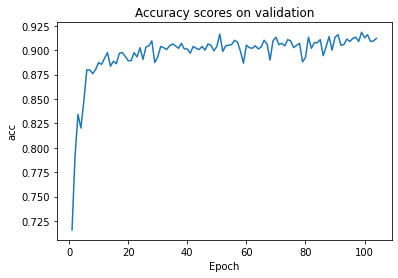

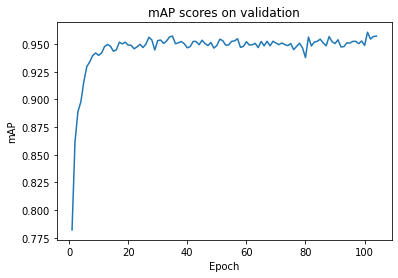

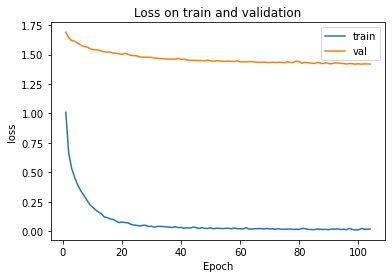

In [ ]:
##Here we're going to visualize output from output dir 19-01-2022_21:28:23 (100 epochs on tiny pretrained model)
output_dir = '/content/drive/MyDrive/colab_notebooks/deep_learning/deep_learning_project/output/19-01-2022_21:28:23'
results_path = os.path.join(output_dir, 'results.csv')
results = pd.read_csv(results_path)
plot_training(results)

In [ ]:
#performance on test set
test_path = os.path.join(output_dir, 'test_performance.csv')
df_test = pd.read_csv(test_path)
df_test[['acc', 'mAP']]

,acc,mAP
0,0.908571,0.948973
